Install MedSAM repo

In [1]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
# download medsam weights
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2024-09-19 06:49:19--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M  19.7MB/s    in 20s     

2024-09-19 06:49:39 (18.1 MB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import cv2

### Functions

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [6]:
def create_bounding_box_from_mask(mask):
    # Find the coordinates of the non-zero pixels in the mask
    coords = np.column_stack(np.where(mask > 0))

    if coords.size == 0:
        print("No object found in the mask.")
        return None

    # Get the bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    return (y_min, x_min, y_max, x_max)

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    return mask

# Load the original image (if you want to draw the bounding box on the original image)
def load_image(image_path):
    image = cv2.imread(image_path)
    return image

In [42]:
# AutoSAM dice function
def get_dice_ji(predict, target):
    predict = predict + 1
    target = target + 1
    tp = np.sum(((predict == 2) * (target == 2)) * (target > 0))
    fp = np.sum(((predict == 2) * (target == 1)) * (target > 0))
    fn = np.sum(((predict == 1) * (target == 2)) * (target > 0))
    ji = float(np.nan_to_num(tp / (tp + fp + fn)))
    dice = float(np.nan_to_num(2 * tp / (2 * tp + fp + fn)))
    return dice, ji

In [8]:
torch.cuda.is_available()

True

In [9]:
##%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [10]:
segmentation_dir = '/content/drive/MyDrive/TAU/Deep_learning_in_medical_imaging/LITS/png/segmentation_0'
image_dir = '/content/drive/MyDrive/TAU/Deep_learning_in_medical_imaging/LITS/png/volume_0'

In [49]:
def inference(img, bbox, h,w):
  #%% image preprocessing and model inference
  img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
  img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
  # convert the shape to (3, H, W)
  img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
  box_np = np.array([bbox])
  # transfer box_np t0 1024x1024 scale
  box_1024 = box_np / np.array([w,h,w ,h]) * 1024
  with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)
  medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, h, w)
  return medsam_seg

def visualize_inference(img, seg, bbox):
  #%% visualize results
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(img)
  show_box(bbox, ax[0])
  ax[0].set_title("Input Image and Bounding Box")
  ax[1].imshow(img)
  show_mask(seg, ax[1])
  show_box(bbox, ax[1])
  ax[1].set_title("MedSAM Segmentation")
  plt.show()



In [44]:
dice_scores = []
from tqdm import tqdm
for mask_name in tqdm(os.listdir(segmentation_dir)):
  mask_path = join(segmentation_dir, mask_name)
  img_path = join(image_dir, mask_name)
  img_np = io.imread(img_path)
  if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
  elif img_np.shape[2] == 4:
    img_3c = img_np[:, :, :3]
  else:
    img_3c = img_np
  H, W, _ = img_3c.shape
  mask = load_mask(mask_path)
  bbox = create_bounding_box_from_mask(mask)
  medsam_seg = inference(img_3c, bbox, H, W)
  dice, ji = get_dice_ji(medsam_seg, mask/255)
  print(f'dice score for {mask_name} {dice}')
  dice_scores.append(dice)
  #visualize_inference(img_3c, medsam_seg, bbox)

  3%|▎         | 1/29 [00:02<01:07,  2.40s/it]

dice score for slice_64.png 0.8233769533731419


  7%|▋         | 2/29 [00:04<01:05,  2.41s/it]

dice score for slice_60.png 0.7490077916561584


 10%|█         | 3/29 [00:08<01:11,  2.77s/it]

dice score for slice_68.png 0.9269702276707531


 14%|█▍        | 4/29 [00:11<01:11,  2.87s/it]

dice score for slice_59.png 0.7358059604089624


 17%|█▋        | 5/29 [00:13<01:04,  2.68s/it]

dice score for slice_50.png 0.7549730276466622


 21%|██        | 6/29 [00:15<00:59,  2.58s/it]

dice score for slice_65.png 0.895279089141905


 24%|██▍       | 7/29 [00:18<00:55,  2.52s/it]

dice score for slice_52.png 0.7963467172152335


 28%|██▊       | 8/29 [00:21<00:55,  2.65s/it]

dice score for slice_67.png 0.9252353278218876


 31%|███       | 9/29 [00:24<00:57,  2.86s/it]

dice score for slice_62.png 0.7773963559545815


 34%|███▍      | 10/29 [00:26<00:51,  2.71s/it]

dice score for slice_56.png 0.655062858704564


 38%|███▊      | 11/29 [00:29<00:47,  2.61s/it]

dice score for slice_46.png 0.6089324618736384


 41%|████▏     | 12/29 [00:31<00:43,  2.55s/it]

dice score for slice_49.png 0.6931480642400443


 45%|████▍     | 13/29 [00:34<00:40,  2.55s/it]

dice score for slice_54.png 0.7638649498124302


 48%|████▊     | 14/29 [00:37<00:43,  2.89s/it]

dice score for slice_45.png 0.24206930209858468


 52%|█████▏    | 15/29 [00:40<00:38,  2.75s/it]

dice score for slice_61.png 0.7623935269731668


 55%|█████▌    | 16/29 [00:42<00:34,  2.64s/it]

dice score for slice_51.png 0.7912893982808022


 59%|█████▊    | 17/29 [00:45<00:30,  2.57s/it]

dice score for slice_63.png 0.8025419091677859


 62%|██████▏   | 18/29 [00:47<00:27,  2.53s/it]

dice score for slice_55.png 0.7509402137989196


 66%|██████▌   | 19/29 [00:52<00:31,  3.14s/it]

dice score for slice_53.png 0.7502385749125225


 69%|██████▉   | 20/29 [00:54<00:26,  2.90s/it]

dice score for slice_69.png 0.8935876297847689


 72%|███████▏  | 21/29 [00:56<00:22,  2.75s/it]

dice score for slice_66.png 0.8745807987688913


 76%|███████▌  | 22/29 [01:01<00:24,  3.45s/it]

dice score for slice_47.png 0.6746666666666666


 79%|███████▉  | 23/29 [01:05<00:21,  3.53s/it]

dice score for slice_48.png 0.5488594762038862


 83%|████████▎ | 24/29 [01:07<00:15,  3.19s/it]

dice score for slice_58.png 0.6801748780897932


 86%|████████▌ | 25/29 [01:10<00:11,  2.97s/it]

dice score for slice_57.png 0.7278551026136345


 90%|████████▉ | 26/29 [01:12<00:08,  2.79s/it]

dice score for slice_72.png 0.7353053435114504


 93%|█████████▎| 27/29 [01:15<00:05,  2.68s/it]

dice score for slice_73.png 0.3975026014568158


 97%|█████████▋| 28/29 [01:18<00:02,  2.96s/it]

dice score for slice_71.png 0.8018582541054451


100%|██████████| 29/29 [01:21<00:00,  2.81s/it]

dice score for slice_70.png 0.9137822184403392


In [45]:
print(np.mean(dice_scores))

0.7397601958756355


In [48]:
np_box = np.array(bbox)
np_box[0]

235

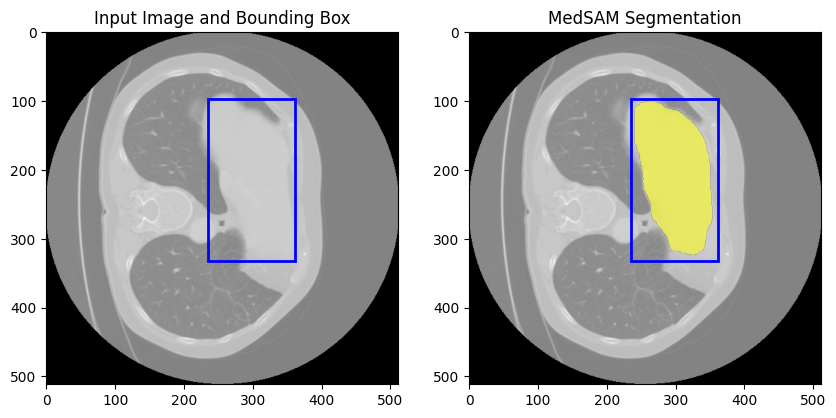

In [50]:
visualize_inference(img_3c, medsam_seg, np.array(bbox))